# 2a. Marketing Budget Optimization

## 1. Preprocessing and EDA

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)



In [215]:
F = r'G:\My Drive\01. DATA ANALYSIS LEARNING MATERIALS\Test for DA\Trusting Social - Data Analytics Technical Screening Test\data\Q2_mkt_data.csv'
df = pd.read_csv(F)


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             300000 non-null  int64 
 1   send_date      300000 non-null  object
 2   estimated_age  300000 non-null  int64 
 3   age_range      300000 non-null  object
 4   channel        300000 non-null  object
 5   coupon         300000 non-null  int64 
 6   clicked        300000 non-null  int64 
 7   last_step      300000 non-null  object
 8   nb_units       300000 non-null  int64 
 9   order_value    300000 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.9+ MB


<Axes: >

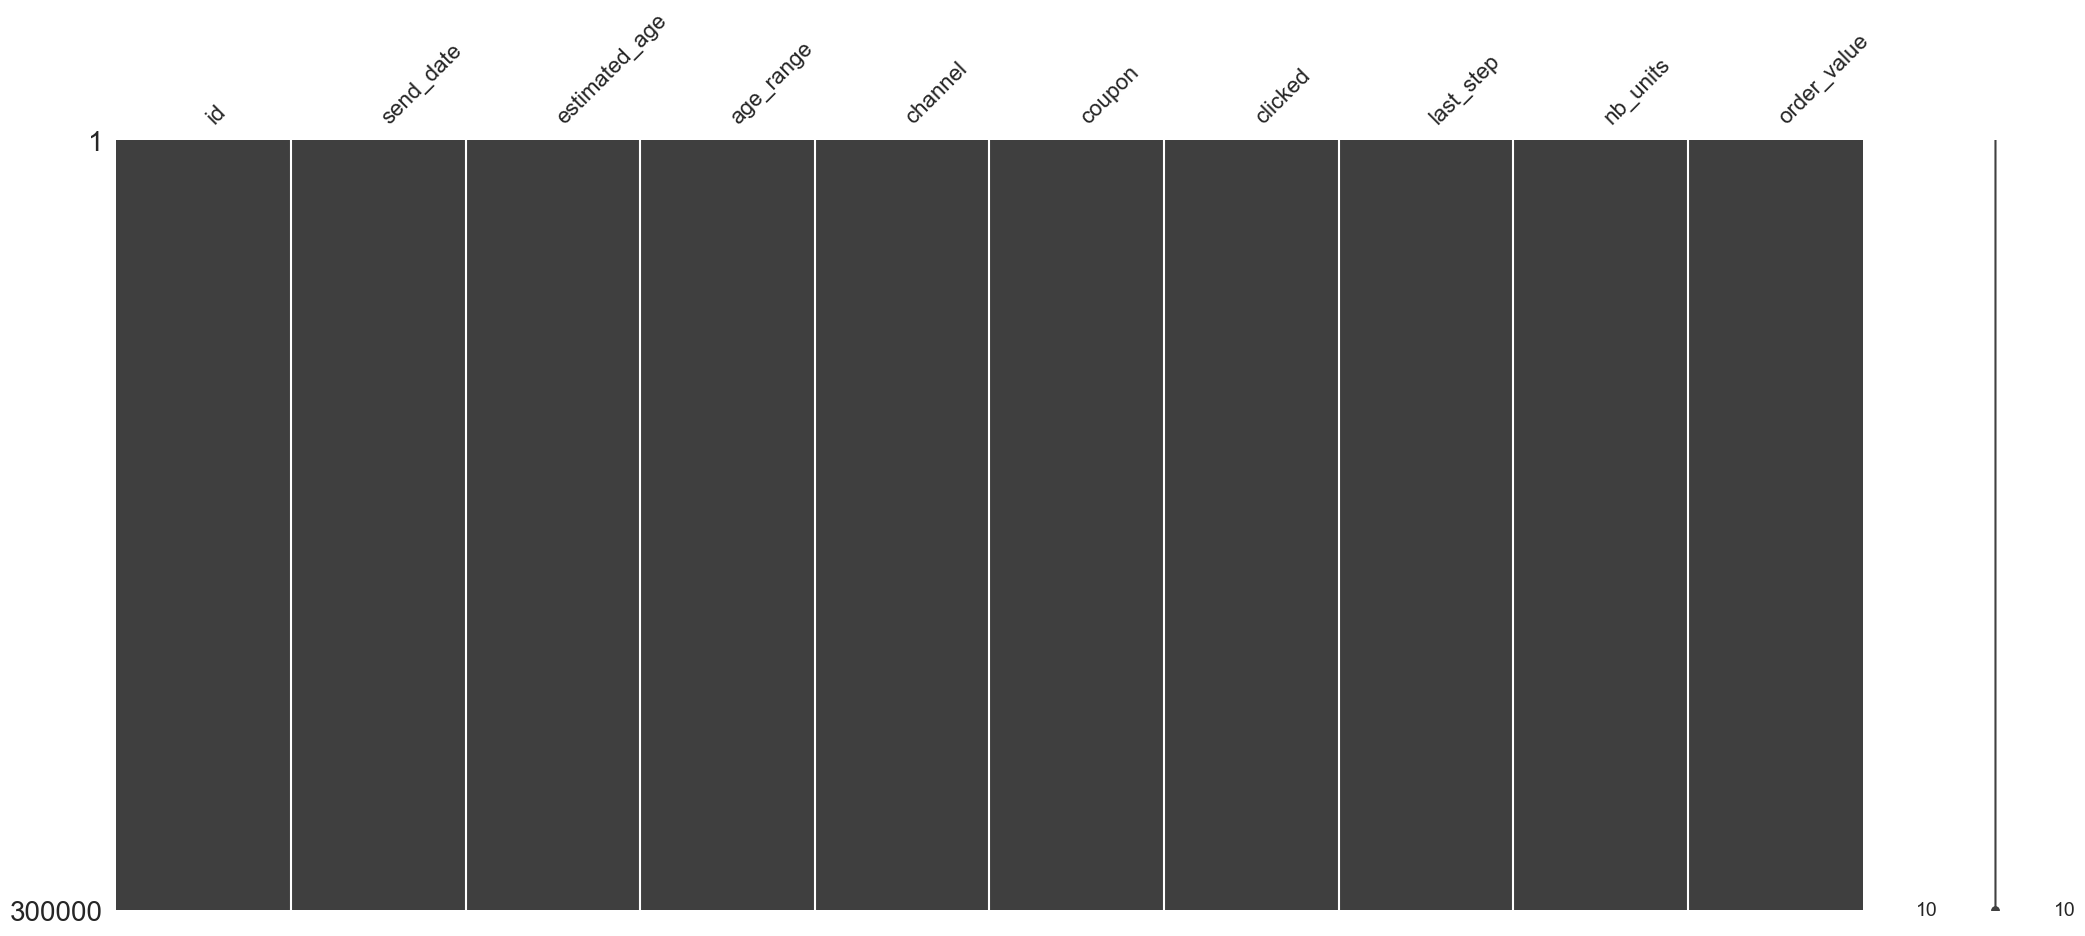

In [217]:
import missingno as msno 

msno.matrix(df)

In [218]:
df.duplicated().any()

False

In [219]:
df.head(4)

,id,send_date,estimated_age,age_range,channel,coupon,clicked,last_step,nb_units,order_value
0,1,2019-04-12,59,46-60,SMS,2,0,received,0,0
1,2,2019-04-08,27,18-30,Email,2,0,received,0,0
2,3,2019-04-05,74,60+,Email,2,0,received,0,0
3,4,2019-04-21,32,31-45,SMS,2,0,received,0,0


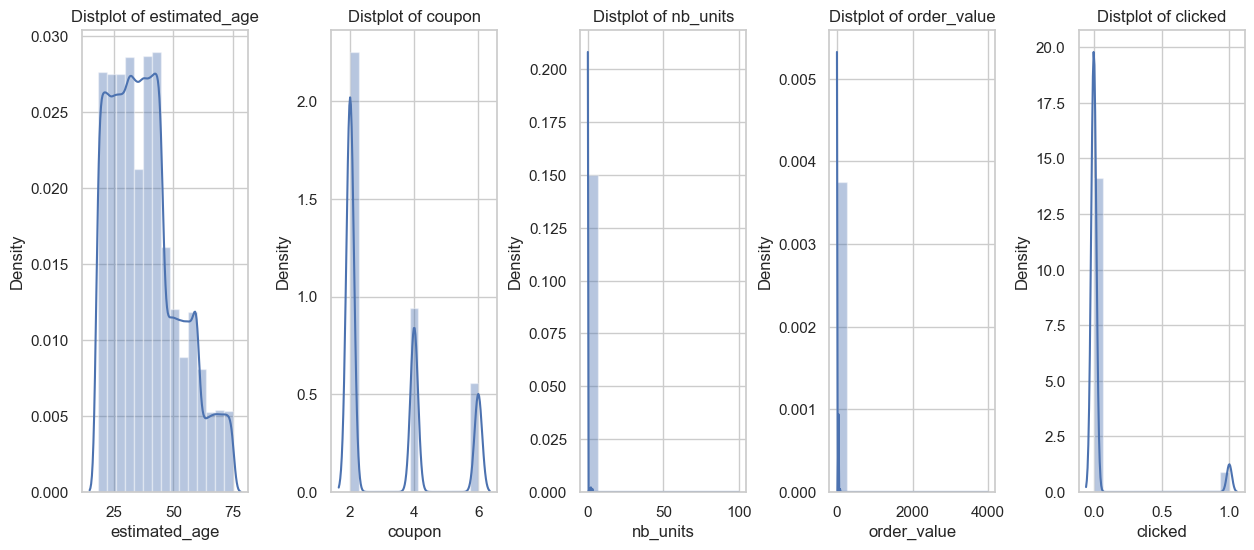

In [220]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['estimated_age' , 'coupon', 'nb_units' ,'order_value','clicked']:
    n += 1
    plt.subplot(1 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [221]:
df.nunique().sort_values()

channel               2
clicked               2
coupon                3
age_range             4
last_step             6
nb_units              7
order_value          14
send_date            31
estimated_age        58
id               300000
dtype: int64

In [222]:

df['coupon_units'] = (df['nb_units']*40-df['order_value'])/df['coupon']
df['mkt_cost'] = df['channel'].apply(lambda x: 0.050 if x == 'SMS' else 0.075)+df['coupon_units']*df['coupon']
df['production_cost'] = df['nb_units'] * 18
df['profit'] = df['order_value']-df['production_cost']-df['mkt_cost']
df['is_received'] = df['last_step'].apply(lambda x: 1 if x == 'received' else 0)
df['is_purchased'] = df['last_step'].apply(lambda x: 1 if x == 'purchased' else 0)
df['is_bounced'] = df['last_step'].apply(lambda x: 1 if x == 'bounced' else 0)
df['is_saw_review'] = df['last_step'].apply(lambda x: 1 if x == 'saw review' else 0)
df['is_a2c'] = df['last_step'].apply(lambda x: 1 if x == 'added to cart' else 0)
df['is_not_payment'] = df['last_step'].apply(lambda x: 1 if x == 'payment page' else 0)


In [223]:
df['coupon'] = df['coupon'].astype('object')

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               300000 non-null  int64  
 1   send_date        300000 non-null  object 
 2   estimated_age    300000 non-null  int64  
 3   age_range        300000 non-null  object 
 4   channel          300000 non-null  object 
 5   coupon           300000 non-null  object 
 6   clicked          300000 non-null  int64  
 7   last_step        300000 non-null  object 
 8   nb_units         300000 non-null  int64  
 9   order_value      300000 non-null  int64  
 10  coupon_units     300000 non-null  float64
 11  mkt_cost         300000 non-null  float64
 12  production_cost  300000 non-null  int64  
 13  profit           300000 non-null  float64
 14  is_received      300000 non-null  int64  
 15  is_purchased     300000 non-null  int64  
 16  is_bounced       300000 non-null  int6

In [225]:
summed_data = df.groupby(['channel','age_range','coupon']).agg({                                      
                                                     'is_received': 'sum',
                                                    'clicked': 'sum',
                                                    'is_saw_review': 'sum',
                                                    'is_bounced': 'sum',                                                    
                                                    'is_a2c': 'sum',
                                                    'is_not_payment': 'sum',
                                                    'is_purchased': 'sum',
                                                    'coupon_units': 'sum',
                                                    'nb_units': 'sum',
                                                    'order_value': 'sum',
                                                    'production_cost': 'sum',
                                                    'mkt_cost': 'sum',
                                                    'profit': 'sum'
                                                    }).reset_index()


summed_data.columns = ['channel','age_range','coupon','total_received', 'total_clicked', 
                       'total_bounced', 'total_saw_review', 'total_a2c', 'total_not_payment', 
                       'total_purchased', 'coupon_units', 'order_unit', 'order_value', 'production_cost',
                      'mkt_cost', 'profit' ]

summed_data

,channel,age_range,coupon,total_received,total_clicked,total_bounced,total_saw_review,total_a2c,total_not_payment,total_purchased,coupon_units,order_unit,order_value,production_cost,mkt_cost,profit
0,Email,18-30,2,26810,1224,422,478,162,20,142,210.0,210,7980,3780,2522.550,1677.450
1,Email,18-30,4,11093,606,221,214,67,11,93,158.0,158,5688,2844,1509.425,1334.575
2,Email,18-30,6,6510,417,150,159,67,3,38,54.0,54,1836,972,843.525,20.475
3,Email,31-45,2,30724,2685,1087,950,255,35,358,564.0,564,21432,10152,3633.675,7646.325
4,Email,31-45,4,13111,988,423,348,73,17,127,200.0,200,7200,3600,1857.425,1742.575
5,Email,31-45,6,7774,598,250,210,57,8,73,113.0,113,3842,2034,1305.900,502.100
6,Email,46-60,2,13402,444,93,184,75,28,64,89.0,89,3382,1602,1216.450,563.550
7,Email,46-60,4,5504,240,61,86,54,19,20,34.0,34,1224,612,566.800,45.200
8,Email,46-60,6,3100,311,75,118,65,22,31,47.0,47,1598,846,537.825,214.175
9,Email,60+,2,6448,76,34,21,8,13,0,0.0,0,0,0,489.300,-489.300


In [226]:

summed_data['viewability'] = (summed_data['total_saw_review']+summed_data['total_a2c']+summed_data['total_not_payment'])/summed_data['total_received']
summed_data['click_rate'] = summed_data['total_clicked']/summed_data['total_received']
summed_data['conversion_rate'] = summed_data['total_purchased']/summed_data['total_clicked']
summed_data['CPC'] = summed_data['mkt_cost']/summed_data['total_clicked']
summed_data['CPV'] = summed_data['mkt_cost']/(summed_data['total_saw_review']+summed_data['total_a2c']+summed_data['total_not_payment'])
summed_data['CPA'] = np.where(summed_data['order_unit'] > 0, summed_data['mkt_cost'] / summed_data['order_unit'], np.nan)
summed_data['ROI'] = summed_data['profit'] / (summed_data['mkt_cost'] + summed_data['production_cost'])
summed_data



,channel,age_range,coupon,total_received,total_clicked,total_bounced,total_saw_review,total_a2c,total_not_payment,total_purchased,...,production_cost,mkt_cost,profit,viewability,click_rate,conversion_rate,CPC,CPV,CPA,ROI
0,Email,18-30,2,26810,1224,422,478,162,20,142,...,3780,2522.550,1677.450,0.024618,0.045655,0.116013,2.060907,3.822045,12.012143,0.266154
1,Email,18-30,4,11093,606,221,214,67,11,93,...,2844,1509.425,1334.575,0.026323,0.054629,0.153465,2.490800,5.169264,9.553323,0.306557
2,Email,18-30,6,6510,417,150,159,67,3,38,...,972,843.525,20.475,0.035177,0.064055,0.091127,2.022842,3.683515,15.620833,0.011278
3,Email,31-45,2,30724,2685,1087,950,255,35,358,...,10152,3633.675,7646.325,0.040359,0.087391,0.133333,1.353324,2.930383,6.442686,0.554657
4,Email,31-45,4,13111,988,423,348,73,17,127,...,3600,1857.425,1742.575,0.033407,0.075357,0.128543,1.879985,4.240696,9.287125,0.319304
5,Email,31-45,6,7774,598,250,210,57,8,73,...,2034,1305.900,502.100,0.035374,0.076923,0.122074,2.183779,4.748727,11.556637,0.150334
6,Email,46-60,2,13402,444,93,184,75,28,64,...,1602,1216.450,563.550,0.021415,0.033129,0.144144,2.739752,4.238502,13.667978,0.199950
7,Email,46-60,4,5504,240,61,86,54,19,20,...,612,566.800,45.200,0.028888,0.043605,0.083333,2.361667,3.564780,16.670588,0.038344
8,Email,46-60,6,3100,311,75,118,65,22,31,...,846,537.825,214.175,0.066129,0.100323,0.099678,1.729341,2.623537,11.443085,0.154770
9,Email,60+,2,6448,76,34,21,8,13,0,...,0,489.300,-489.300,0.006514,0.011787,0.000000,6.438158,11.650000,NaN,-1.000000


In [227]:
summed_data = summed_data.drop(columns=['total_bounced','coupon_units','total_saw_review', 'profit', 
                                        'total_bounced','total_not_payment', 'order_value', 'total_a2c',
                                        'production_cost','order_unit'])

summed_data

,channel,age_range,coupon,total_received,total_clicked,total_purchased,mkt_cost,viewability,click_rate,conversion_rate,CPC,CPV,CPA,ROI
0,Email,18-30,2,26810,1224,142,2522.550,0.024618,0.045655,0.116013,2.060907,3.822045,12.012143,0.266154
1,Email,18-30,4,11093,606,93,1509.425,0.026323,0.054629,0.153465,2.490800,5.169264,9.553323,0.306557
2,Email,18-30,6,6510,417,38,843.525,0.035177,0.064055,0.091127,2.022842,3.683515,15.620833,0.011278
3,Email,31-45,2,30724,2685,358,3633.675,0.040359,0.087391,0.133333,1.353324,2.930383,6.442686,0.554657
4,Email,31-45,4,13111,988,127,1857.425,0.033407,0.075357,0.128543,1.879985,4.240696,9.287125,0.319304
5,Email,31-45,6,7774,598,73,1305.900,0.035374,0.076923,0.122074,2.183779,4.748727,11.556637,0.150334
6,Email,46-60,2,13402,444,64,1216.450,0.021415,0.033129,0.144144,2.739752,4.238502,13.667978,0.199950
7,Email,46-60,4,5504,240,20,566.800,0.028888,0.043605,0.083333,2.361667,3.564780,16.670588,0.038344
8,Email,46-60,6,3100,311,31,537.825,0.066129,0.100323,0.099678,1.729341,2.623537,11.443085,0.154770
9,Email,60+,2,6448,76,0,489.300,0.006514,0.011787,0.000000,6.438158,11.650000,NaN,-1.000000


<Axes: >

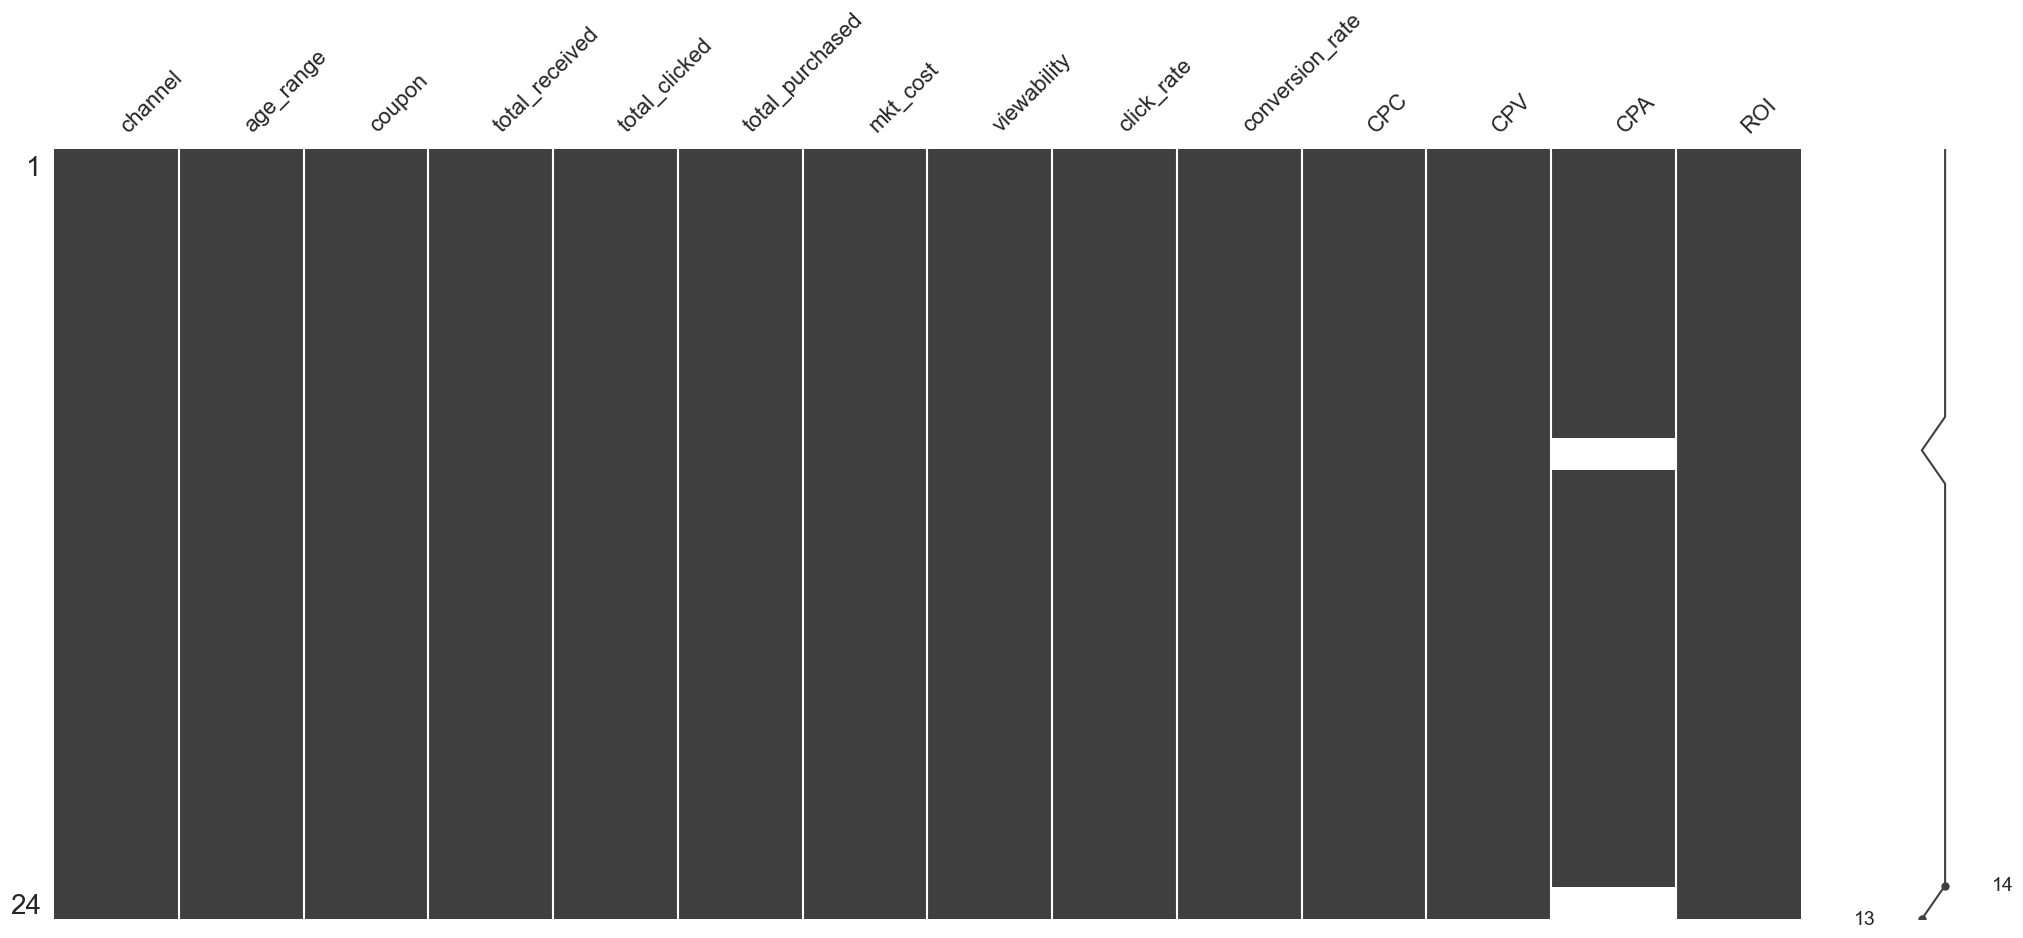

In [228]:
import missingno as msno 
msno.matrix(summed_data)

In [229]:
summed_data.describe()

,coupon,total_received,total_clicked,total_purchased,mkt_cost,viewability,click_rate,conversion_rate,CPC,CPV,CPA,ROI
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,22.000000,24.000000
mean,4.000000,11759.750000,740.250000,77.583333,1164.509375,0.036463,0.060431,0.085114,2.638537,4.233858,23.243942,0.039430
std,1.668115,10162.701936,709.245174,83.762561,877.580719,0.022180,0.034607,0.049764,2.967911,3.729854,31.789417,0.496986
min,2.000000,1650.000000,6.000000,0.000000,93.600000,0.002680,0.003215,0.000000,1.079244,1.390255,5.098424,-1.000000
25%,2.000000,5045.500000,238.750000,15.750000,525.693750,0.020678,0.032488,0.044699,1.353758,2.292879,8.313978,-0.079555
50%,4.000000,7731.500000,563.000000,67.000000,1072.625000,0.035208,0.056535,0.095739,1.905026,3.247581,11.499861,0.177360
75%,6.000000,13975.500000,990.750000,108.000000,1414.006250,0.043677,0.077808,0.123691,2.393950,4.367704,15.467599,0.325758
max,6.000000,38108.000000,2685.000000,358.000000,3633.675000,0.094005,0.143869,0.153465,15.600000,18.720000,133.050000,0.662778


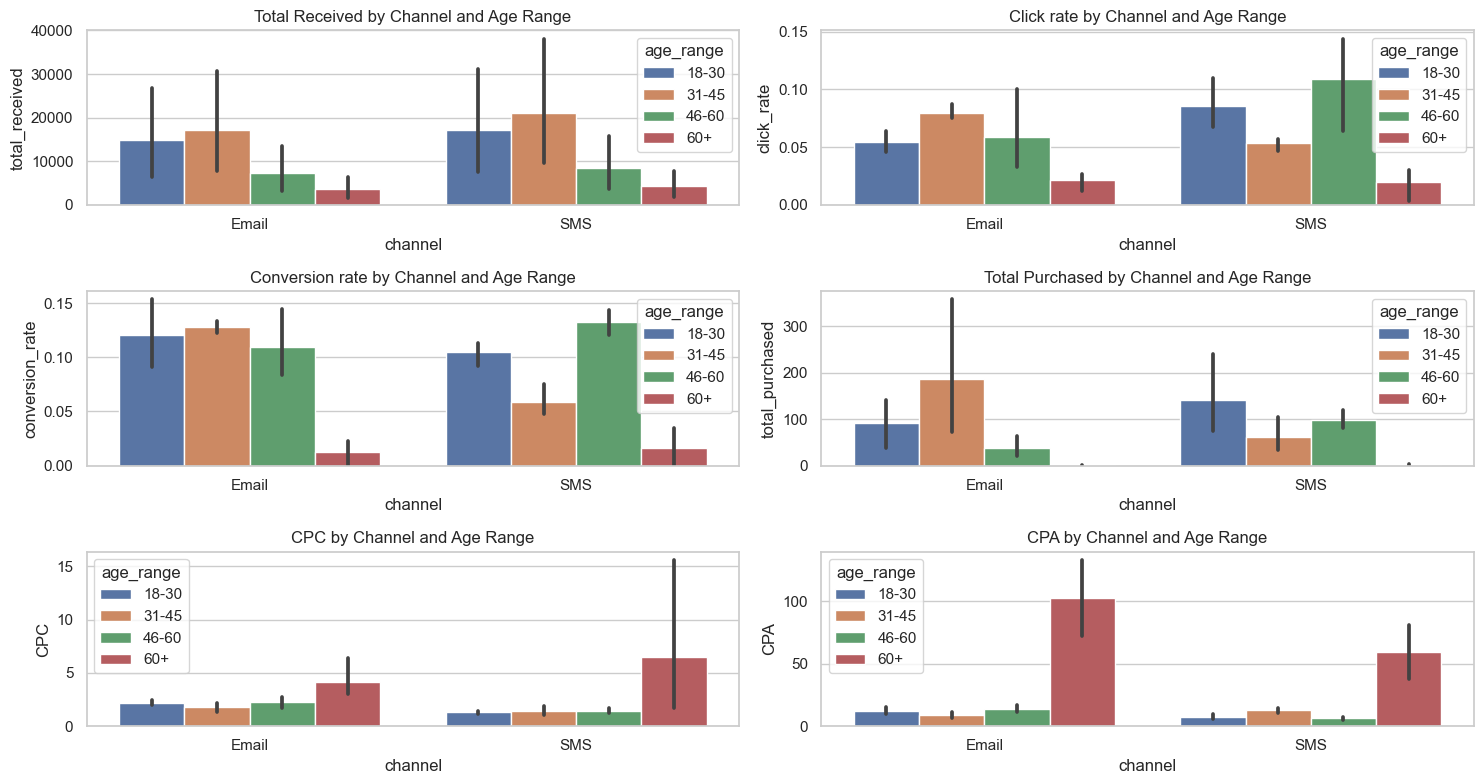

In [230]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

# Plot 1: Total Received by Channel and Age Range
sns.barplot(x='channel', y='total_received', hue='age_range', data=summed_data, ax=axes[0, 0])
axes[0, 0].set_title('Total Received by Channel and Age Range')

# Plot 2: Click rate by Channel and Age Range
sns.barplot(x='channel', y='click_rate', hue='age_range', data=summed_data, ax=axes[0, 1])
axes[0, 1].set_title('Click rate by Channel and Age Range')

# Plot 3: Conversion rate by Channel and Age Range
sns.barplot(x='channel', y='conversion_rate', hue='age_range', data=summed_data, ax=axes[1, 0])
axes[1, 0].set_title('Conversion rate by Channel and Age Range')

# Plot 4: Total Purchased by Channel and Age Range
sns.barplot(x='channel', y='total_purchased', hue='age_range', data=summed_data, ax=axes[1, 1])
axes[1, 1].set_title('Total Purchased by Channel and Age Range')

# Plot 5: CPC by Channel and Age Range
sns.barplot(x='channel', y='CPC', hue='age_range', data=summed_data, ax=axes[2, 0])
axes[2, 0].set_title('CPC by Channel and Age Range')

# Plot 6: CPA by Channel and Age Range
sns.barplot(x='channel', y='CPA', hue='age_range', data=summed_data, ax=axes[2, 1])
axes[2, 1].set_title('CPA by Channel and Age Range')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

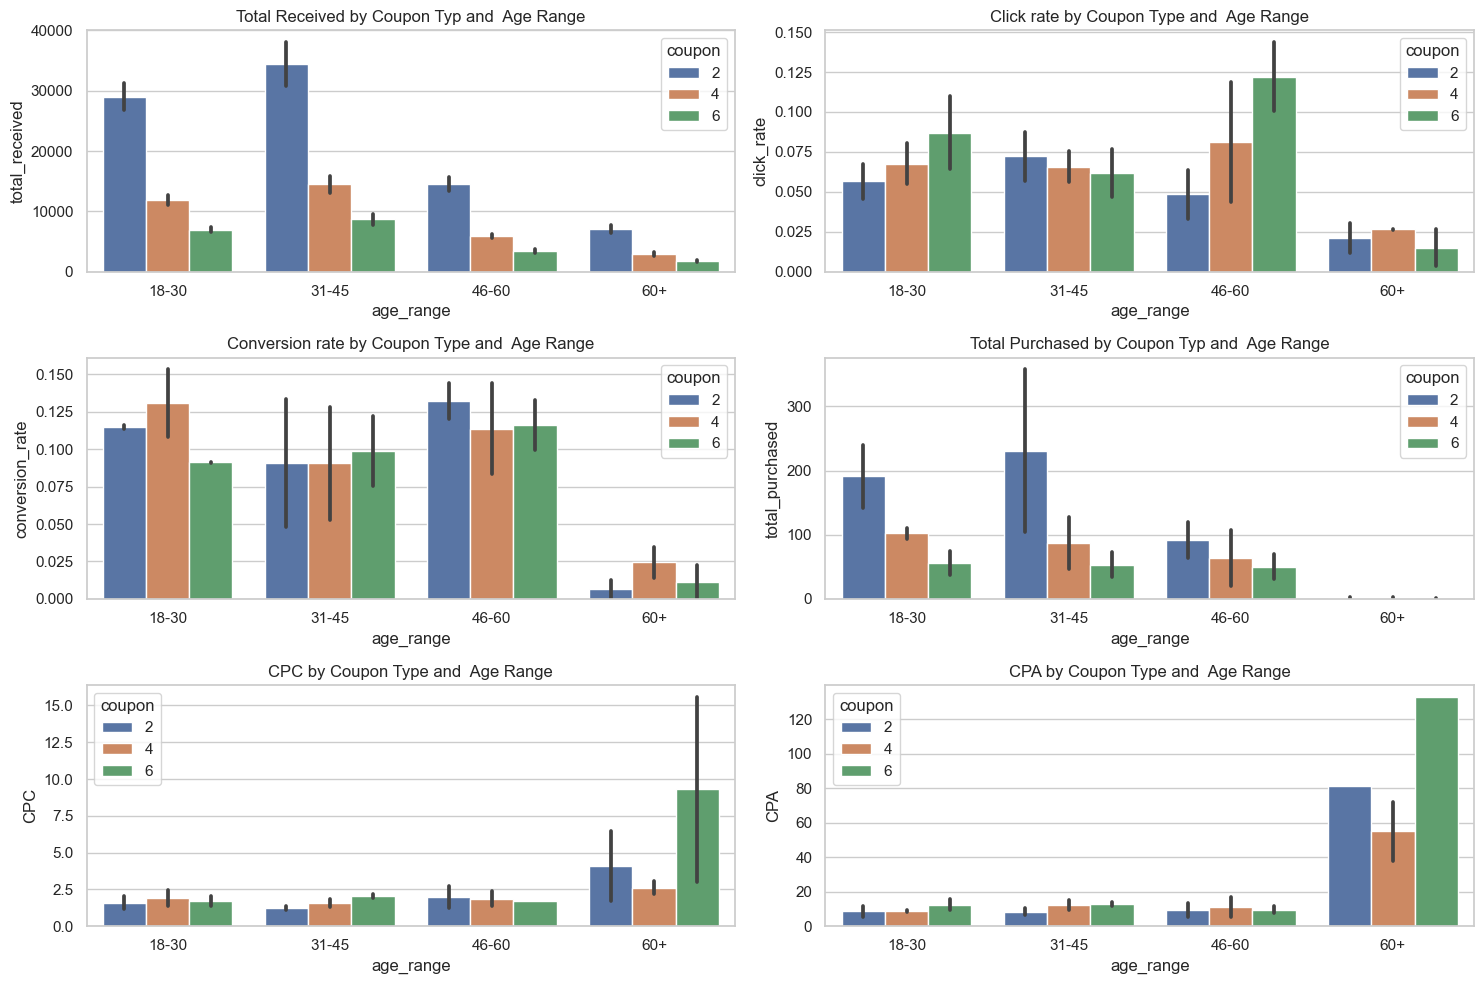

In [231]:

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Plot 1: Total Received by Coupon Type and Age Range
sns.barplot(x='age_range', y='total_received', hue='coupon', data=summed_data, ax=axes[0, 0])
axes[0, 0].set_title('Total Received by Coupon Typ and  Age Range')

# Plot 2: Click rate by Coupon Type and Age Range
sns.barplot(x='age_range', y='click_rate', hue='coupon', data=summed_data, ax=axes[0, 1])
axes[0, 1].set_title('Click rate by Coupon Type and  Age Range')

# Plot 3: Conversion rate by Coupon Type and Age Range
sns.barplot(x='age_range', y='conversion_rate', hue='coupon', data=summed_data, ax=axes[1, 0])
axes[1, 0].set_title('Conversion rate by Coupon Type and  Age Range')

# Plot 4: Total Purchased by Coupon Type and Age Range
sns.barplot(x='age_range', y='total_purchased', hue='coupon', data=summed_data, ax=axes[1, 1])
axes[1, 1].set_title('Total Purchased by Coupon Typ and  Age Range')

# Plot 5: CPC by Coupon Type and Age Range
sns.barplot(x='age_range', y='CPC', hue='coupon', data=summed_data, ax=axes[2, 0])
axes[2, 0].set_title('CPC by Coupon Type and  Age Range')

# Plot 6: CPA by Coupon Type and Age Range
sns.barplot(x='age_range', y='CPA', hue='coupon', data=summed_data, ax=axes[2, 1])
axes[2, 1].set_title('CPA by Coupon Type and  Age Range')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [232]:
sns.set(style="whitegrid")

# Pivot the DataFrame to get ROI values for each combination
df_pivot = summed_data.pivot_table(index='age_range', columns=['channel', 'coupon'], values='ROI', aggfunc='mean').reset_index()
df_pivot

channel age_range     Email                           SMS                    
coupon                    2         4         6         2         4         6
0           18-30  0.266154  0.306557  0.011278  0.662778  0.385170  0.240165
1           31-45  0.554657  0.319304  0.150334  0.345122  0.090648  0.055686
2           46-60  0.199950  0.038344  0.154770  0.620856  0.571575  0.318135
3             60+ -1.000000 -0.601108 -0.774909 -0.617090 -0.352052 -1.000000

## 2. Key Observations:

### Age Range Influence:
Younger age groups (18-30) tend to have higher engagement and conversion rates. Older age groups (60+) show lowest engagement and conversion rates, with varying costs.
### Channel Performance:
Email generally performs better in terms of engagement and ROI across age ranges.
SMS has its strengths, especially in the 18-30 and 46-60 age range, with lower CPC and CPA.



### SMS channel for 18-30 and 46-60 with voucher 2  gained higest return on investment

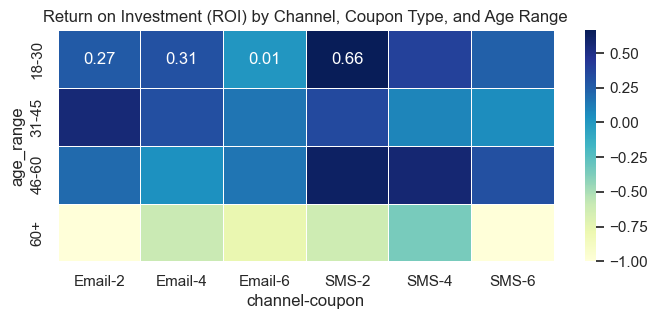

In [233]:
sns.set(style="whitegrid")

df_pivot2 = summed_data.pivot_table(index='age_range', columns=['channel','coupon'], values='ROI', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(8, 3))
sns.heatmap(df_pivot2, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Return on Investment (ROI) by Channel, Coupon Type, and Age Range')
plt.show()

## 3. Simulation  
#### Next quarter, marketing department has a budget of $60,000 to spend on online campaigns

In [234]:
channel_pivot = summed_data.pivot_table(
                        index=['channel', 'age_range','coupon'],
                        values=['total_received', 'total_clicked', 'total_purchased', 
                                'viewability', 'click_rate', 'conversion_rate', 'CPC', 'CPV', 'CPA', 'ROI'],
                        aggfunc={
                            'total_received': 'sum',
                            'total_clicked': 'sum',
                            'total_purchased': 'sum',
                            'viewability': 'mean',
                            'click_rate': 'mean',
                            'conversion_rate': 'mean',
                            'CPC': 'mean',
                            'CPV': 'mean',
                            'CPA': 'mean',
                            'ROI': 'mean'
                        }
                    ).reset_index()
channel_pivot['distribution']=channel_pivot['total_received']/channel_pivot['total_received'].sum()
channel_pivot['coupon'] = channel_pivot['coupon'].astype(object)
channel_pivot

,channel,age_range,coupon,CPA,CPC,CPV,ROI,click_rate,conversion_rate,total_clicked,total_purchased,total_received,viewability,distribution
0,Email,18-30,2,12.012143,2.060907,3.822045,0.266154,0.045655,0.116013,1224,142,26810,0.024618,0.094992
1,Email,18-30,4,9.553323,2.490800,5.169264,0.306557,0.054629,0.153465,606,93,11093,0.026323,0.039304
2,Email,18-30,6,15.620833,2.022842,3.683515,0.011278,0.064055,0.091127,417,38,6510,0.035177,0.023066
3,Email,31-45,2,6.442686,1.353324,2.930383,0.554657,0.087391,0.133333,2685,358,30724,0.040359,0.108860
4,Email,31-45,4,9.287125,1.879985,4.240696,0.319304,0.075357,0.128543,988,127,13111,0.033407,0.046454
5,Email,31-45,6,11.556637,2.183779,4.748727,0.150334,0.076923,0.122074,598,73,7774,0.035374,0.027545
6,Email,46-60,2,13.667978,2.739752,4.238502,0.199950,0.033129,0.144144,444,64,13402,0.021415,0.047485
7,Email,46-60,4,16.670588,2.361667,3.564780,0.038344,0.043605,0.083333,240,20,5504,0.028888,0.019502
8,Email,46-60,6,11.443085,1.729341,2.623537,0.154770,0.100323,0.099678,311,31,3100,0.066129,0.010984
9,Email,60+,2,NaN,6.438158,11.650000,-1.000000,0.011787,0.000000,76,0,6448,0.006514,0.022846


<Axes: >

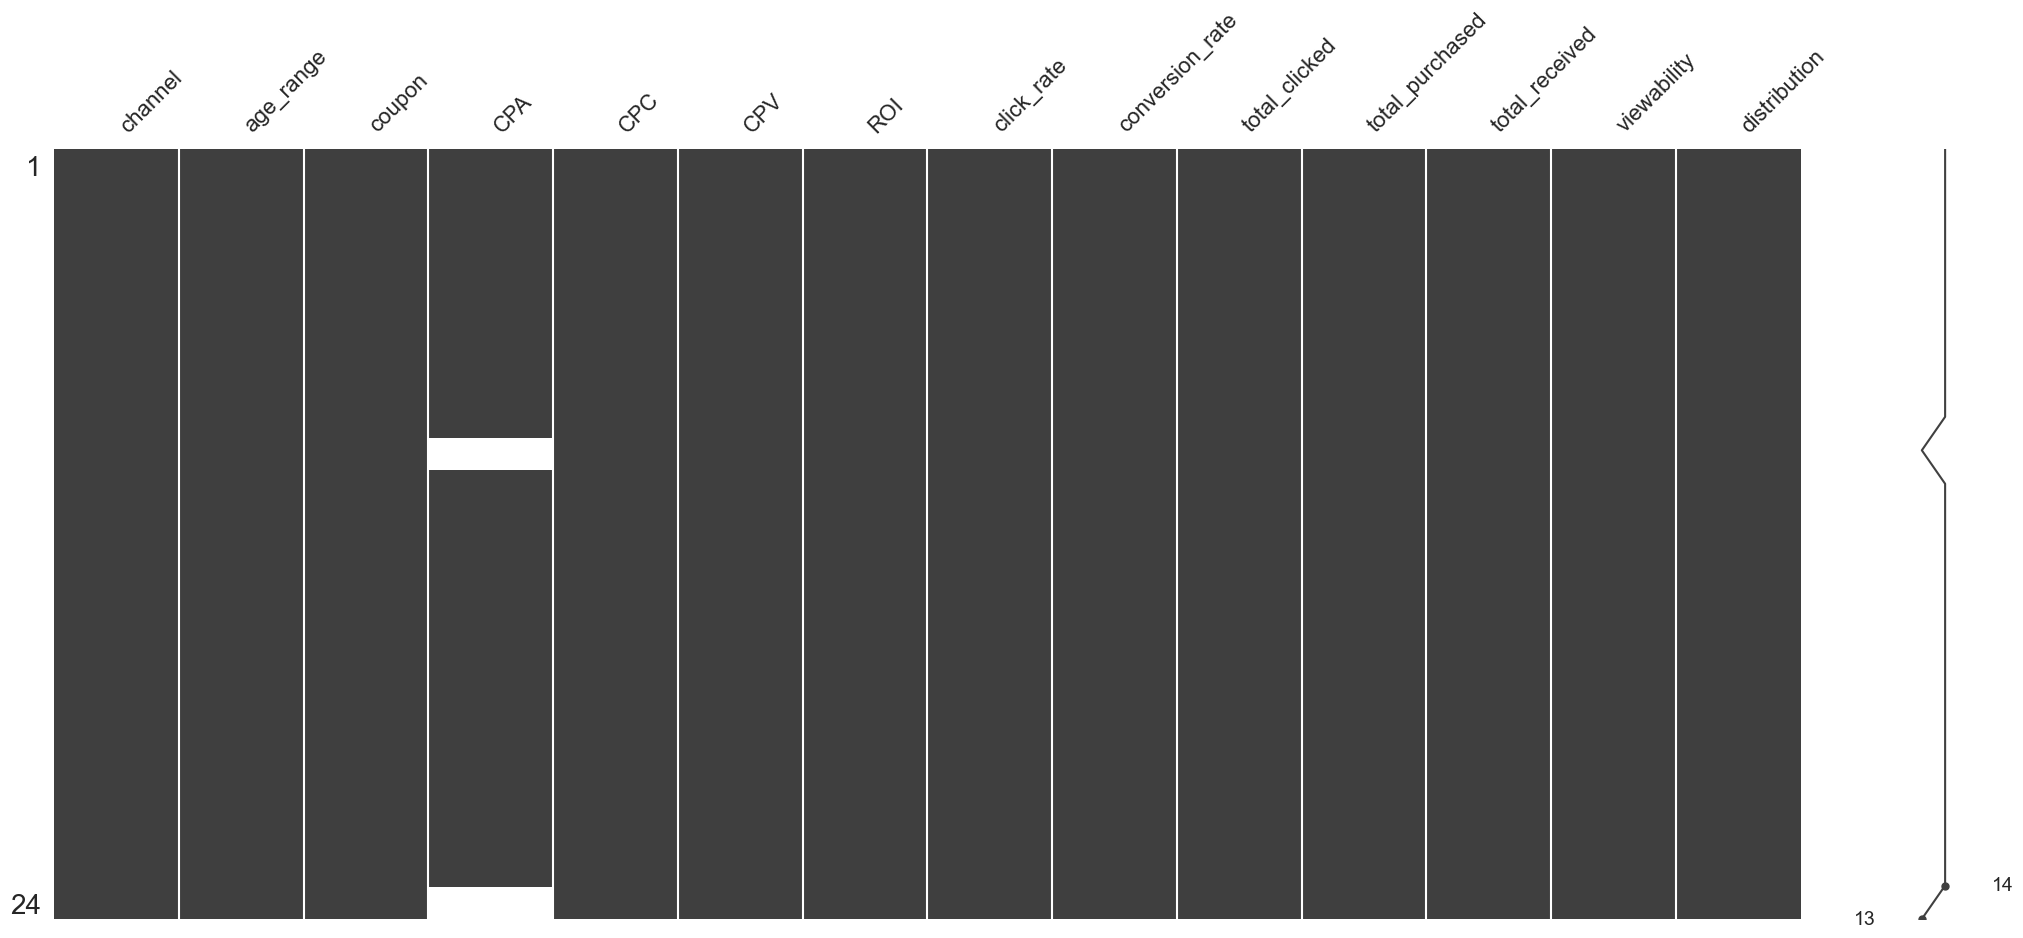

In [235]:
import missingno as msno 
msno.matrix(channel_pivot)

In [236]:
channel_pivot['CPA'].fillna(0, inplace=True)

In [237]:
cate_columns = channel_pivot.loc[:, channel_pivot.dtypes == np.object_].columns.tolist()
cate_columns

['channel', 'age_range', 'coupon']

In [238]:
num_columns = channel_pivot.loc[:, channel_pivot.dtypes != np.object_].columns.tolist()
num_columns

['CPA',
 'CPC',
 'CPV',
 'ROI',
 'click_rate',
 'conversion_rate',
 'total_clicked',
 'total_purchased',
 'total_received',
 'viewability',
 'distribution']

In [239]:
X = channel_pivot[num_columns]
y = channel_pivot['ROI'] 

In [240]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [241]:
coefficients = model.coef_

In [242]:
weights = np.abs(coefficients) / np.sum(np.abs(coefficients))

In [243]:
feature_weights = dict(zip(X.columns, weights))
feature_weights

{'CPA': 1.162375391840501e-16,
 'CPC': 3.336427088879603e-16,
 'CPV': 2.240348843259977e-15,
 'ROI': 0.9999999999998934,
 'click_rate': 1.2424217645461723e-14,
 'conversion_rate': 8.740447293473277e-14,
 'total_clicked': 5.512035296979894e-18,
 'total_purchased': 7.768550282863695e-17,
 'total_received': 4.6331358779653956e-18,
 'viewability': 4.029961721227479e-15,
 'distribution': 2.6258670514661146e-17}

In [244]:
channel_pivot['weighted_score'] = 0 
# Update the weighted_score with the weighted feature value
for feature in num_columns:
    if feature in feature_weights:      
        channel_pivot['weighted_score'] += channel_pivot[feature] * feature_weights[feature]

In [245]:
# Exclude negative or undesired scores that generates negative ROI
channel_pivot = channel_pivot[channel_pivot['weighted_score'] > 0]

In [246]:

# Normalize the scores to sum to 1
channel_pivot['normalized_score'] = channel_pivot['weighted_score'] / channel_pivot['weighted_score'].sum()

# Allocate the budget based on the normalized scores
budget = 60000
channel_pivot['budget_allocation'] = channel_pivot['normalized_score'] * budget
channel_pivot['budget_allocation_pct'] = round(channel_pivot['budget_allocation']/ budget*100.0,2)

In [247]:
age_range_allocation = channel_pivot.groupby('age_range')['budget_allocation'].sum()


In [248]:
age_pools = {'18-30': 300000, '31-45': 350000, '46-60': 500000}  # setting 60+ to zero as it was negative
capped_allocations = {age_range: min(age_range_allocation[age_range], age_pools[age_range]) for age_range in age_pools}

In [249]:
channel_pivot['adjusted_budget_allocation'] = channel_pivot.apply(lambda row: (row['budget_allocation'] / age_range_allocation[row['age_range']]) 
                                                * capped_allocations[row['age_range']], axis=1)
channel_pivot['budget_allocation_pct'] = round(channel_pivot['adjusted_budget_allocation']/ budget*100.0,2)

## 4. Final allocation
### Based on historical ROI and atttributed features, the budget of MKT campaign is allocated by age-range and coupon value as below
Age Range 60+ generate negative ROI so statistically it's supposed to be excluded out of marketing plan

In [250]:
channel_pivot[['channel','age_range','coupon','budget_allocation_pct']]

,channel,age_range,coupon,budget_allocation_pct
0,Email,18-30,2,5.03
1,Email,18-30,4,5.79
2,Email,18-30,6,0.21
3,Email,31-45,2,10.48
4,Email,31-45,4,6.03
5,Email,31-45,6,2.84
6,Email,46-60,2,3.78
7,Email,46-60,4,0.72
8,Email,46-60,6,2.92
12,SMS,18-30,2,12.53


In [251]:
budget_allocation = channel_pivot.pivot_table(
                        index=['age_range'],
                        columns =['channel'],
                        values=['budget_allocation_pct'],
                        aggfunc={'sum'}).reset_index()
budget_allocation

age_range budget_allocation_pct       
                                    sum       
channel                           Email    SMS
0           18-30                 11.03  24.35
1           31-45                 19.35   9.28
2           46-60                  7.42  28.54

# 2b. Recommendation for maximize net profit

### 1. Focus on High-ROI Channels: 
Allocate more budget to channels with higher ROI, especially where the ROI is significantly above the average. For example, campaigns targeting the <span style="color:blue">18-30 age range via SMS.</span> seem to have higher ROIs than other combinations. Prioritize and expand these high-performing channels.

### 2. Optimize or Reassess Underperforming Channels: 
Channels that show a negative ROI, particularly those targeting  <span style="color:blue">the 60+ age range.</span>, should be thoroughly reviewed. Try to understand why these channels are underperforming—whether it's the message, the channel itself, audience targeting, or any other factor. Consider pausing these campaigns or experimenting with different strategies to improve their performance.

### 3. Improve Conversion Rates: 
Identify channels with high click rates but lower conversion rates. Work on improving the conversion funnel for these channels, which may include optimizing landing pages, simplifying the checkout process, or providing more compelling calls to action.

### 4. Adjust Coupon Strategy: 
Analyze the impact of different coupon values on ROI and other performance metrics. It seems that in some cases, higher coupon values correlate with higher ROI, but this is not always the case. Determine the optimal coupon value for each age range and channel to maximize the conversion rate without sacrificing profit margins.

### 5. Leverage Click and Viewability Rates:
High click rates and viewability suggest engaging content and effective targeting. Use insights from these metrics to produce similar content and targeting strategies for other campaigns. Additionally, test different creative materials and targeting options to find the best combination for each age group.

### 6. Evaluate CPA and CPC:
Keep an eye on the cost per acquisition (CPA) and cost per click (CPC) metrics. High costs can quickly erode ROI. Consider tactics to reduce these costs, such as better targeting, bid adjustments, or optimizing ad schedules.

